# Fringing in Astronomical CCDs

A study of the mechanisms and phenomenonology of fringing in astronomical CCDs.

This [accompanying talk](https://confluence.slac.stanford.edu/display/LSSTDESC/SSim+2016-09-01) has more details (LSST-DESC members only).

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.interpolate
import astropy.table
import astropy.units as u

## Material Optical Properties

Initialize a dictionary of refraction index interpolating functions that accept wavelength in nanometers.  The result may be complex valued in case of non-zero extinction. Dictionary keys are molecular formulas, e.g. "SiO2".

In [3]:
def load_refraction_data(kind='linear'):
    
    interpolators = {}
    
    # Vacuum.
    interpolators['Vacuum'] = lambda wlen: np.ones_like(wlen)
    
    # Load silicon optical properties from this paper linked from
    # https://www2.pvlighthouse.com.au/Resources/Photovoltaic%20materials/Refractive%20index/Refractive%20index.aspx):
    # C. Schinke, P.C Peest, J. Schmidt, R. Brendel, K. Bothe, M.R Vogt, I. Kröger,
    # S. Winter, A. Schirmacher, S. Lim, et al.,'Uncertainty analysis for the coefficient
    #of band-to-band absorption of crystalline silicon', AIP Advances 5, p. 067168, 2015.
    abs_table = astropy.table.Table.read('data/Si-absorption.csv', format='ascii.csv', names=('wlen', 'k', 'a'))
    table = astropy.table.Table.read('data/Si-index.csv', format='ascii.csv', names=('wlen', 'n'))
    wlen = abs_table['wlen']
    k = abs_table['k']
    
    # Interpolate n onto the finer grid used for k.
    n = np.interp(wlen, table['wlen'], table['n'])
    
    # Build a linear interpolator of the complex index of refraction vs wavelength [nm].
    n = n + 1.j * k
    interpolators['Si'] = scipy.interpolate.interp1d(wlen, n, copy=True, kind=kind)
    
    # Read tabulated Si3N4 data from
    # http://refractiveindex.info/?shelf=main&book=Si3N4&page=Philipp
    table = astropy.table.Table.read('data/Si3N4-index.csv', format='ascii.csv', names=('wlen', 'n'))
    # Convert from um to nm.
    wlen = 1e3 * table['wlen']
    n = table['n']    
    interpolators['Si3N4'] = scipy.interpolate.interp1d(wlen, n, copy=True, kind=kind)

    # Read SiO2 tabulated data from
    # http://refractiveindex.info/?shelf=main&book=SiO2&page=Malitson
    table = astropy.table.Table.read('data/SiO2-index.csv', format='ascii.csv', names=('wlen', 'n'))
    # Convert from um to nm.
    wlen = 1e3 * table['wlen']
    n = table['n']    
    interpolators['SiO2'] = scipy.interpolate.interp1d(wlen, n, copy=True, kind=kind)

    # Read MgF2 tabulated data from
    # http://refractiveindex.info/?shelf=main&book=MgF2&page=Li-o
    table = astropy.table.Table.read('data/MgF2-index.csv', format='ascii.csv', names=('wlen', 'n'))
    # Convert from um to nm.
    wlen = 1e3 * table['wlen']
    n = table['n']    
    interpolators['MgF2'] = scipy.interpolate.interp1d(wlen, n, copy=True, kind=kind)
    
    return interpolators

In [4]:
index_of_refraction = load_refraction_data()

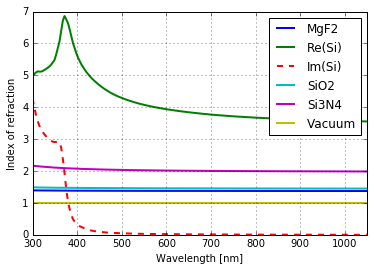

In [5]:
def plot_refraction(wlen_min=300., wlen_max=1050.):
    wlen = np.linspace(wlen_min, wlen_max, 200)
    for name, n_func in index_of_refraction.iteritems():
        n = n_func(wlen)
        im_n = np.imag(n)
        if np.any(im_n != 0):
            plt.plot(wlen, np.real(n), lw=2, label='Re({0})'.format(name))
            plt.plot(wlen, im_n, lw=2, ls='--', label='Im({0})'.format(name))
        else:
            plt.plot(wlen, n, lw=2, label=name)
    plt.legend()
    plt.xlabel('Wavelength [nm]')
    plt.ylabel('Index of refraction')
    plt.xlim(wlen_min, wlen_max)
    plt.grid()

plot_refraction()
#plt.savefig('index_of_refraction.pdf')

## Fresnel Equations

Use the [Fresnel equations](https://en.wikipedia.org/wiki/Fresnel_equations) to calculate reflection and transmission coefficients at an interface:

In [6]:
def get_fresnel_coefficients(n1, n2, theta_i):
    cth_i = np.cos(theta_i)
    # Use Snell's law, n1 sin(theta_i) = n2 cos(theta_i), to calculate cos(theta_t).
    # Note that both sides of Snell's law must be real valued but cos(theta_t) is
    # generally a complex value if either n1 or n2 is complex.
    cth_t = np.sqrt(1 - (n1 / n2 * np.sin(theta_i)) ** 2)
    # Calculate amplitude reflection and transmission coefficients for each polarization.
    rs = (n1 * cth_i - n2 * cth_t) / (n1 * cth_i + n2 * cth_t)
    rp = (n2 * cth_i - n1 * cth_t) / (n1 * cth_t + n2 * cth_i)
    ts = 1 + rs
    tp = 2 * n1 * cth_i / (n1 * cth_t + n2 * cth_i)
    
    return rs, rp, ts, tp

Reproduce a [wikipedia plot](https://en.wikipedia.org/wiki/Fresnel_equations#/media/File:Amptitude_Ratios_air_to_glass.JPG):

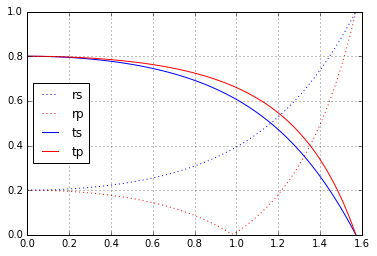

In [7]:
def plot_reflect(n1=1.0, n2=1.5):
    th = np.linspace(0., 0.5 * np.pi, 91)
    rs, rp, ts, tp = get_fresnel_coefficients(n1, n2, th)
    plt.plot(th, np.abs(rs), 'b:', label='rs')
    plt.plot(th, np.abs(rp), 'r:', label='rp')
    plt.plot(th, np.abs(ts), 'b-', label='ts')
    plt.plot(th, np.abs(tp), 'r-', label='tp')
    plt.legend(loc='center left')
    plt.grid()

plot_reflect()

## STIS Model

Implement the model of http://iopscience.iop.org/article/10.1086/345913/pdf and try to reproduce Figure 4.  I'm not sure what quantity Fig.4 is plotting (axis is labeled "Fringe Amplitude" and appears to have some trend subtracted), but the power reflection coefficient has very similar structure.

In [8]:
def stis_model(apply_scattering=True, save=None):
    
    # Define the structure of Table 1.
    material = ('Vacuum', 'MgF2', 'Si3N4', 'Si', 'SiO2', 'Si3N4', 'Si', 'Si3N4')
    thickness_um = (np.inf, 0.06, 0.03, 14.0206, 0.28, 0.24, 0.81, np.inf)
    roughness_um = (0., 0.01, 0.02, 0.06, 0.06, 0.08, 0.10, 0.11)
    
    # Assume normal incidence.
    theta = 0.
    
    # Define the wavelengths to calculate, matching the coverage of Figs. 3 and 4.
    wlen = np.linspace(600., 1000., 3201)
    wlen_um = 1e-3 * wlen
    
    # Precompute roughness vectors for each layer.
    if apply_scattering:
        w = np.exp(-0.5 * np.array(roughness_um)[:, np.newaxis] ** 2 *
                   (4 * np.pi / wlen_um) ** 2)

    # Initialize at the bottom interface. For normal incidence, both polarizations
    # have the same coefficients, so we only use the s-polarized values.
    nkp1 = index_of_refraction[material[-1]](wlen)
    nk = index_of_refraction[material[-2]](wlen)
    rk, _, tk, _ = get_fresnel_coefficients(nk, nkp1, theta)
    #rk = (nk - nkp1) / (nk + nkp1)
    #tk = 2 * nk / (nk + nkp1)
    if apply_scattering:
        rk *= w[-1]
    layer = len(material) - 2
    n_btm = nk
    
    # Iterate upwards through the layers.
    while layer > 0:
        layer -= 1
        nkp1, rkp1, tkp1 = nk, rk, tk
        nk = index_of_refraction[material[layer]](wlen)
        r, _, t, _ = get_fresnel_coefficients(nk, nkp1, theta)
        #r = (nk - nkp1) / (nk + nkp1)
        #t = 2 * nk / (nk + nkp1)
        if apply_scattering:
            r *= w[layer + 1]
        dkp1 = thickness_um[layer + 1]
        # I don't think this should be real(n) here...
        beta = 2 * np.pi * dkp1 * nkp1 / wlen_um
        exp_beta = np.exp(1.j * beta)
        exp_2beta = np.exp(2.j * beta)
        denom = (1. + r * rkp1 * exp_2beta)
        rk = (r + rkp1 * exp_2beta) / denom
        tk = (t * tkp1 * exp_beta) / denom
        print '[{0}] {1:6s} -> {2:6s} d={3:5.2f} r={4:+5.2f} t={5:+5.2f}'.format(
            layer, material[layer], material[layer + 1], dkp1, rk[-1], tk[-1])
        
    # Calculate the power transmission, reflection and absorption coefficients.
    n_top = nk
    T = np.real(n_btm / n_top) * np.abs(tk) ** 2
    R = np.abs(rk) ** 2
    A = 1 - T - R
    
    plt.plot(wlen, T, label='Power Transmission')
    plt.plot(wlen, R, label='Power Reflection')
    plt.plot(wlen, A, label='Power Absorption')
    plt.ylabel('Power Coefficients')
    plt.xlabel('Wavelength [nm]')
    plt.legend(loc='upper center')
    plt.axhline(0., color='k', ls='--')
    plt.axhline(1., color='k', ls='--')
    plt.grid()
    
    plt.tight_layout()
    if save:
        plt.savefig(save)

[5] Si3N4  -> Si     d= 0.81 r=-0.11-0.11j t=+0.71-0.59j
[4] SiO2   -> Si3N4  d= 0.24 r=-0.22-0.07j t=-0.51+0.57j
[3] Si     -> SiO2   d= 0.28 r=+0.19+0.18j t=+0.09-1.14j
[2] Si3N4  -> Si     d=14.02 r=-0.22+0.23j t=+0.40-0.67j
[1] MgF2   -> Si3N4  d= 0.03 r=-0.47+0.01j t=+0.48-0.37j
[0] Vacuum -> MgF2   d= 0.06 r=-0.41-0.36j t=+0.48-0.10j


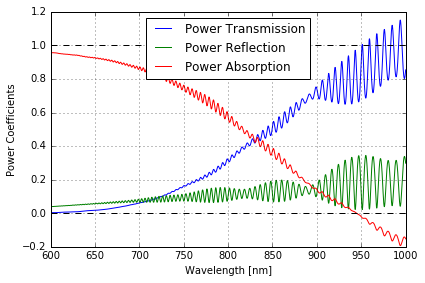

In [9]:
stis_model(apply_scattering=True, save='stis-model.pdf')

[5] Si3N4  -> Si     d= 0.81 r=-0.25-0.26j t=+0.68-0.64j
[4] SiO2   -> Si3N4  d= 0.24 r=-0.45-0.16j t=-0.45+0.60j
[3] Si     -> SiO2   d= 0.28 r=+0.18+0.38j t=-0.14-1.20j
[2] Si3N4  -> Si     d=14.02 r=-0.43+0.31j t=+0.30-0.74j
[1] MgF2   -> Si3N4  d= 0.03 r=-0.65-0.06j t=+0.40-0.44j
[0] Vacuum -> MgF2   d= 0.06 r=-0.47-0.52j t=+0.44-0.18j


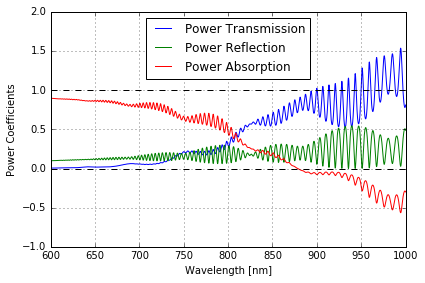

In [10]:
stis_model(apply_scattering=False, save='stis-no-scatter.pdf')

## TMM Examples

Use the [tmm package](https://github.com/sbyrnes321/tmm) for the remaining EM calculations:

In [11]:
import tmm

Use TMM to implement the STIS model, but without any roughness scattering:

In [12]:
def stis_tmm(save=None):
    # Define the structure of Table 1.
    material = ('Vacuum', 'MgF2', 'Si3N4', 'Si', 'SiO2', 'Si3N4', 'Si', 'Si3N4')
    thickness_um = (np.inf, 0.06, 0.03, 14.0206, 0.28, 0.24, 0.81, np.inf)
    
    # Assume normal incidence.
    theta = 0.
    
    # Define the wavelengths to calculate, matching the coverage of Figs. 3 and 4.
    wlen = np.linspace(600., 1000., 3201)
    wlen_um = 1e-3 * wlen
    
    R = np.empty_like(wlen)
    T = np.empty_like(wlen)
    for i, w in enumerate(wlen):
        n_list = [index_of_refraction[m](w) for m in material]
        result = tmm.coh_tmm('s', n_list, thickness_um, theta, 1e-3 * w)
        R[i] = result['R']
        T[i] = result['T']
    A = 1 - R - T
        
    plt.plot(wlen, T, label='Power Transmission')
    plt.plot(wlen, R, label='Power Reflection')
    plt.plot(wlen, A, label='Power Absorption')
    plt.ylabel('Power Coefficients')
    plt.xlabel('Wavelength [nm]')
    plt.legend(loc='center left')
    plt.grid()
    
    plt.tight_layout()
    if save:
        plt.savefig(save)

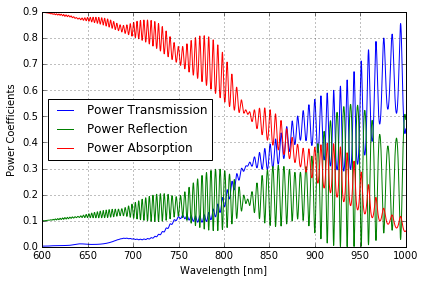

In [13]:
stis_tmm(save='stis-tmm.pdf')

## Fringing in LSST Sensors

### LSST Converging Beam

Parameterize the on-axis photon bundle with the focal ratio $f$, diameter $D$ and effective area $A$ and model the surface that photons originate from as an annulus with $r_{min} \le r \le r_{max}$, where
$$
r_{max} = D/2 \quad , \quad A = \pi( r_{max}^2 - r_{min}^2 ) \; .
$$
The annulus is separated from the focal point by $L = f D$, so the corresponding range of incidence angles is:
$$
\tan\theta_{max} = \frac{f}{2} \quad , \quad
\tan\theta_{min} = \frac{f}{2} \sqrt{1 - \frac{A}{\pi(D/2)^2}}
$$
Angles $\theta'$ within a medium with index of refraction $n$ are smaller according to Snell's law,
$$
\sin\theta = n \sin\theta' \; ,
$$
which modifies the focal ratio to be
$$
f' = f n \sqrt{1 + \frac{n^2 - 1}{(2 f n)^2}}
$$
and adds a Jacobian factor:
$$
\frac{d\theta}{d\theta'} = \frac{n\cos\theta'}{\sqrt{1 - n^2 \sin^2\theta'}} \; .
$$
Note that we are assuming that $n$ is real above, which is only true for $\lambda > 700$ nm in silicon.

Air:  14.3 deg < theta <  22.1 deg, f = 1.234
 Si:   3.9 deg < theta <   6.0 deg, f = 4.784 @ 900.0 nm where n=3.613


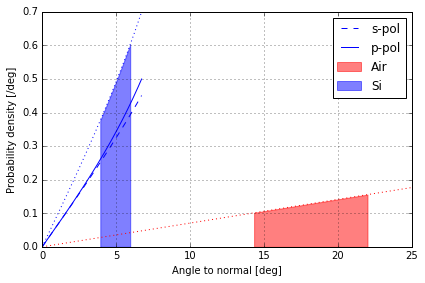

In [14]:
def calculate_optics(f=1.234, D=8.36 * u.m, A=33.212 * u.m**2, wlen=900., save=None):
    tan_max = 1 / (2.0 * f)
    tan_min = tan_max * np.sqrt(1 - A / (np.pi * (0.5 * D) ** 2))
    th0 = np.arctan([tan_min, tan_max])
    print 'Air: {0:5.1f} deg < theta < {1:5.1f} deg, f = {2:.3f}'.format(
        np.rad2deg(th0[0]), np.rad2deg(th0[1]), f)
    
    n_Si = np.real(index_of_refraction['Si'](wlen))
    th0_Si = np.arcsin(np.sin(th0) / n_Si)
    f_Si = f * n_Si * np.sqrt(1 + (n_Si ** 2 - 1) / (2 * f * n_Si) ** 2)
    
    print ' Si: {0:5.1f} deg < theta < {1:5.1f} deg, f = {2:.3f} @ {3:.1f} nm where n={4:.3f}'.format(
        np.rad2deg(th0_Si[0]), np.rad2deg(th0_Si[1]), f_Si, wlen, float(n_Si))
    
    th = np.linspace(0., 25., 200) * u.deg
    th_rad = th.to(u.rad).value
    pdf = 2. * th_rad / (th0[1] ** 2 - th0[0] ** 2)
    pupil = (th_rad >= th0[0]) & (th_rad < th0[1])
    pdf /= np.sum(pdf[pupil] * np.gradient(th.value)[pupil])
    plt.plot(th, pdf, 'r:')
    plt.fill_between(th[pupil].value, pdf[pupil], color='r', alpha=0.5, label='Air')

    th_Si_rad = np.arcsin(np.sin(th_rad) / n_Si)
    jacobian = n_Si * np.cos(th_Si_rad) / np.cos(th_rad)
    th_Si_deg = np.rad2deg(th_Si_rad)
    plt.plot(th_Si_deg, pdf * jacobian, 'b:')
    plt.fill_between(th_Si_deg[pupil], pdf[pupil] * jacobian[pupil], color='b', alpha=0.5, label='Si')
    
    cth, cth_Si = np.cos(th_rad), np.cos(th_Si_rad)
    Ts = 1 - ((cth - n_Si * cth_Si) / (cth + n_Si * cth_Si)) ** 2
    Tp = 1 - ((cth_Si - n_Si * cth) / (cth_Si + n_Si * cth)) ** 2
    plt.plot(th_Si_deg, pdf * jacobian * Ts, 'b--', label='s-pol')
    plt.plot(th_Si_deg, pdf * jacobian * Tp, 'b-', label='p-pol')
    
    plt.legend(loc='upper right')
    plt.xlabel('Angle to normal [deg]')
    plt.ylabel('Probability density [/deg]')
    
    plt.grid()
    plt.tight_layout()
    if save:
        plt.savefig(save)

calculate_optics(save='lsst_beam.pdf')

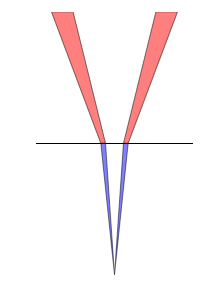

In [15]:
def draw_beam(f=1.234, D=8.36 * u.m, A=33.212 * u.m**2, wlen=900., save=None):
    tan_max = 1 / (2.0 * f)
    tan_min = tan_max * np.sqrt(1 - A / (np.pi * (0.5 * D) ** 2))
    th0 = np.arctan([tan_min, tan_max])
    n0, n1 = 1, np.real(index_of_refraction['Si'](wlen))
    th1 = np.arcsin(np.sin(th0) * n0 / n1)

    fig = plt.figure(figsize=(3, 6))
    axes = plt.gca()

    xy1 = [[0, -1], [np.sin(th1[0]), 0], [np.sin(th1[1]), 0],]
    axes.add_patch(matplotlib.patches.Polygon(
            xy1, fc='b', ec='k', closed=True, alpha=0.5))
    axes.add_patch(matplotlib.patches.Polygon(
            [[-x,y] for x,y in xy1], fc='b', ec='k', closed=True, alpha=0.5))
    
    xy0 = [[xy1[1][0], 0], [xy1[1][0]+np.sin(th0[0]), 1],
           [xy1[2][0]+np.sin(th0[1]), 1], [xy1[2][0], 0]]
    axes.add_patch(matplotlib.patches.Polygon(
            xy0, fc='r', ec='k', closed=True, alpha=0.5))
    axes.add_patch(matplotlib.patches.Polygon(
            [[-x,y] for x,y in xy0], fc='r', ec='k', closed=True, alpha=0.5))

    plt.xlim(-0.6, +0.6)
    plt.ylim(-1, 1)
    plt.axhline(0, c='k')
    axes.set_aspect(1)
    plt.axis('off')
    plt.tight_layout()
    if save:
        plt.savefig(save)
    
draw_beam(save='beam.pdf')

### Photon Absorption in Sensor Bulk

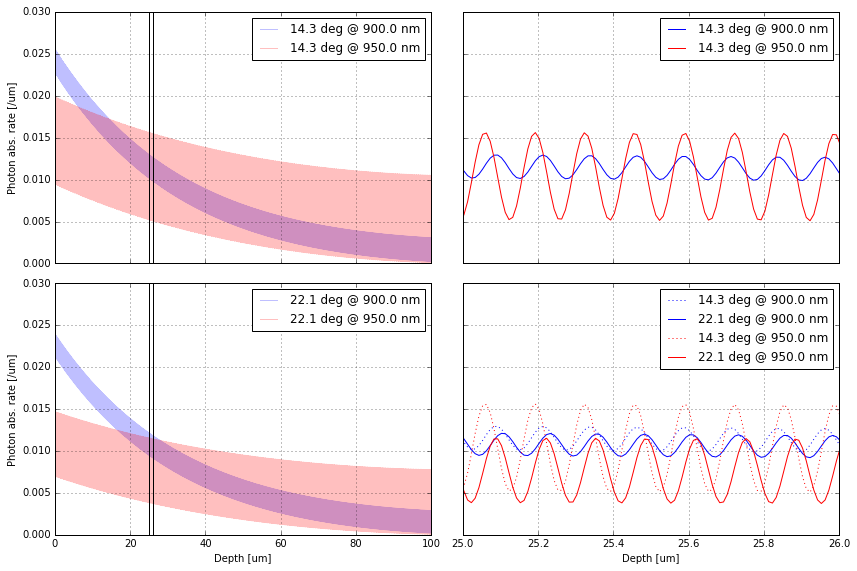

In [16]:
def absorption_profile(zoom=(25., 26.), save=None):
    
    # Define the CCD structure.
    material = ('Vacuum', 'MgF2', 'Si3N4', 'Si', 'SiO2', 'Si', 'Si3N4')
    thickness_um = (np.inf, 0.06, 0.03, 100., 0.15, 1.0, np.inf)
    
    # Parameters to use for each calculation.
    thetas = np.array([14.3, 22.1]) * u.deg
    wlens = np.array([900, 950]) * u.nm
    pol = 's'
    
    # Calculate absorption on fine grid to resolve lambda/(2n) scale.
    dz = np.linspace(0., 100., 10000)
    
    # Initialize 2x2 plots.
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex='col', sharey='row')
    
    for wlen, c in zip(wlens, ('b', 'r')):

        # Calculate indices of refraction at this wavelength.
        n_list = [index_of_refraction[m](wlen.to(u.nm).value) for m in material]

        for row, theta in enumerate(thetas):
        
            absor_tot = np.zeros_like(dz)
            results = tmm.coh_tmm(pol, n_list, thickness_um, theta.to(u.rad).value, wlen.to(u.um).value)
            absor = tmm.position_resolved(3, dz, results)['absor']
            axes[row][0].plot(
                dz, absor, label='{0:.1f} @ {1:.1f}'.format(theta, wlen), ls='-', c=c, alpha=0.25)
            axes[row][1].plot(
                dz, absor, label='{0:.1f} @ {1:.1f}'.format(theta, wlen), ls='-', c=c)
            if row == 0:
                # Superimpose dotted curves on the other zoom plot.
                axes[1][1].plot(
                    dz, absor, label='{0:.1f} @ {1:.1f}'.format(theta, wlen), ls=':', c=c)            
    
    for x in zoom:
        axes[0][0].axvline(x, c='k', ls='-')
        axes[1][0].axvline(x, c='k', ls='-')
    axes[1][0].set_xlim(0., 100.)
    axes[1][1].set_xlim(*zoom)

    axes[1][0].set_xlabel('Depth [um]')
    axes[1][1].set_xlabel('Depth [um]')
    axes[0][0].set_ylabel('Photon abs. rate [/um]')
    axes[1][0].set_ylabel('Photon abs. rate [/um]')

    for row in axes:
        for ax in row:
            ax.legend()
            ax.grid()

    plt.tight_layout()
    if save:
        plt.savefig(save)
    
absorption_profile(save='absorption-profile.png')

In [17]:
def diff_absorption_vs_wlen(th_min=14.3*u.deg, th_max=22.1*u.deg,
                            wlen_min=800.*u.nm, wlen_max=1050.*u.nm,
                            lsst_beam=True, multilayer=True):
    """
    Calculate the absorption A(wlen) and its derivative dA/dz
    for unpolarized light over a range of wavelengths.
    """
    wlen_um = np.linspace(wlen_min.to(u.um).value, wlen_max.to(u.um).value, 200)
    
    if lsst_beam:
        # Integrate over incidence angles in the LSST beam.
        th_rad = np.linspace(th_min.to(u.rad).value, th_max.to(u.rad).value, 100)
        wgt = th_rad / np.sum(th_rad)
    else:
        # Use normal incidence.
        th_rad = np.array([0.])
        wgt = np.array([1.])

    # Define the CCD structure.
    if multilayer:
        material = ('Vacuum', 'MgF2', 'Si3N4', 'Si', 'SiO2', 'Si', 'Si3N4')
        thickness_um = (np.inf, 0.06, 0.03, 100., 0.15, 1.0, np.inf)
        si_index = 3
    else:
        material = ('Vacuum', 'Si', 'Si3N4')
        thickness_um = (np.inf, 100., np.inf)
        si_index = 1
    assert material[si_index] == 'Si'

    dz = np.linspace(0., 100., 10000)
    absor_tot = np.zeros((len(dz), len(wlen_um)))
    absor_sum = np.zeros_like(wlen_um)
    for i, wavelength in enumerate(wlen_um * u.um):
        n_list = [index_of_refraction[m](wavelength.to(u.nm).value) for m in material]
        for theta, weight in zip(th_rad, wgt):
            for pol in 'sp':
                results = tmm.coh_tmm(pol, n_list, thickness_um, theta, wavelength.to(u.um).value)
                absor = tmm.position_resolved(si_index, dz, results)['absor']
                absor_tot[:, i] += 0.5 * weight * absor
                absor_sum[i] += 0.5 * weight * (1. - results['T'] - results['R'])

    extent = (wlen_min.value, wlen_max.value, dz[0], dz[-1])
    return absor_tot, extent, absor_sum

Calculate for nominal LSST beam and sensor structure (takes a few minutes because of the angular integration):

In [18]:
absor, extent, absor_sum = diff_absorption_vs_wlen(lsst_beam=True, multilayer=True)

Calculate for normal incidence (faster because of no angular integration):

In [19]:
absor_normal, extent, absor_sum_normal = diff_absorption_vs_wlen(lsst_beam=False)

Compare with a monolayer 100um of silicon at normal incidence:

In [20]:
absor_mono, extent, absor_sum_mono = diff_absorption_vs_wlen(lsst_beam=False, multilayer=False)

Calculate and plot the differential absorption integrated over the LSST beam for wavelengths covering the LSST z & y bands.

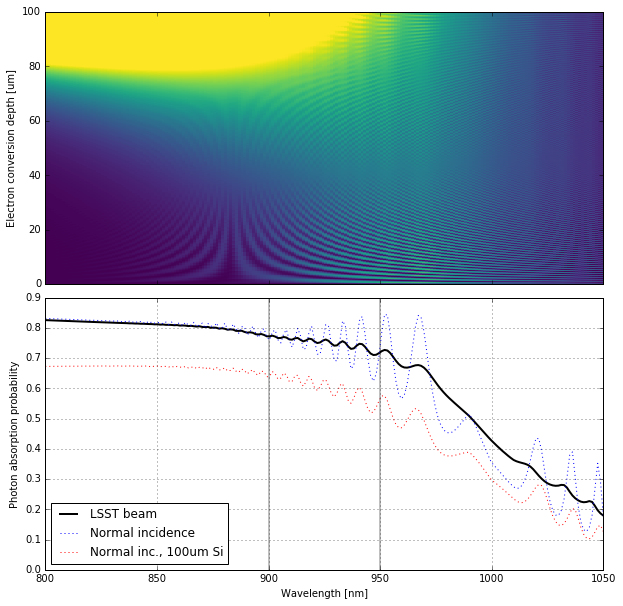

In [21]:
def plot_absorption(save=None):

    fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    vmin, vmax = np.percentile(absor, (0.1, 90))
    ax[0].imshow(absor, interpolation='none', extent=extent, vmin=vmin, vmax=vmax,
               origin='upper', aspect='auto', cmap='viridis')
    ax[0].set_ylabel('Electron conversion depth [um]')

    n_dz, n_wlen = absor.shape
    wlen = np.linspace(extent[0], extent[1], n_wlen)
    dz = np.linspace(extent[2], extent[3], n_dz)

    # Check that differential distribution of A is consistent with 1-(T+R).
    assert np.allclose(absor_sum, np.trapz(absor, dz, axis=0), rtol=1e-2, atol=1e-6)

    # Plot the integrated conversion probability.
    ax[1].plot(wlen, absor_sum, 'k-', lw=2, label='LSST beam')
    ax[1].plot(wlen, absor_sum_normal, 'b:', label='Normal incidence')
    ax[1].plot(wlen, absor_sum_mono, 'r:', label='Normal inc., 100um Si')
    ax[1].legend(loc='lower left')
    ax[1].set_ylim(0, None)
    ax[1].grid()
    ax[1].set_ylabel('Photon absorption probability')
    ax[1].set_xlabel('Wavelength [nm]')
    
    ax[1].axvline(900, c='k', lw=2, alpha=0.25)
    ax[1].axvline(950, c='k', lw=2, alpha=0.25)
    
    plt.subplots_adjust(hspace=0.05)
    if save:
        plt.savefig(save)

plot_absorption('abs_vs_wlen.png')

### Thickness Variations

Calculate the effects of a linear tilt of a single interface in the sensor structure, which leads to anticorrelated thickness variations in the adjacent layers.

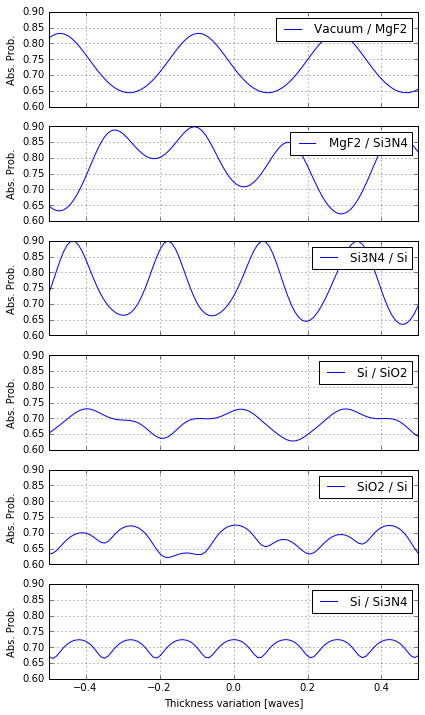

In [22]:
def absorption_vs_thickness(th_min=14.3*u.deg, th_max=22.1*u.deg,
                            nwaves=0.5, wlen=950.*u.nm, save=None):
    """
    Plot the total photon absorption when each interface is linearly perturbed in turn.
    Results are integrated over beam angles and polarizations and calculated for a
    single wavelength.
    """
    # Calculate the thickness variation of the upper layer.
    dthick_waves = np.linspace(-nwaves, +nwaves, 100)
    dthick_um = wlen.to(u.um).value * dthick_waves
    
    # Initialize integration over incidence angles in the LSST beam.
    th_rad = np.linspace(th_min.to(u.rad).value, th_max.to(u.rad).value, 100)
    wgt = th_rad / np.sum(th_rad)

    # Define the CCD structure.
    material = ('Vacuum', 'MgF2', 'Si3N4', 'Si', 'SiO2', 'Si', 'Si3N4')
    thickness_um = [np.inf, 0.06, 0.03, 100., 0.15, 1.0, np.inf]
    n_list = [index_of_refraction[m](wlen.to(u.nm).value) for m in material]
    n_interfaces = len(material) - 1
    
    # Initialize plots.
    fig, axes = plt.subplots(n_interfaces, 1, sharey=True, sharex=True,
                             figsize=(6, 10), squeeze=True)

    # Loop  over interfaces to perturb.
    for i in range(n_interfaces):

        upper = i
        lower = i + 1
        label = '{0} / {1}'.format(material[upper], material[lower])
        
        absor_sum = np.zeros(len(dthick_waves))

        for j, dthick in enumerate(dthick_um):
            # Apply a linear perturbation to this interface.
            new_thickness_um = thickness_um[:]
            new_thickness_um[upper] = thickness_um[upper] + dthick
            new_thickness_um[lower] = thickness_um[lower] - dthick

            # Integrate over angles and polarizations.
            for theta, weight in zip(th_rad, wgt):
                for pol in 'sp':
                    results = tmm.coh_tmm(pol, n_list, new_thickness_um, theta, wlen.to(u.um).value)
                    absor_sum[j] += 0.5 * weight * (1. - results['T'] - results['R'])
                    
        axes[i].plot(dthick_waves, absor_sum, label=label)
        axes[i].legend()
        axes[i].set_ylabel('Abs. Prob.')
        axes[i].grid()

    axes[-1].set_xlabel('Thickness variation [waves]')
    axes[-1].set_xlim(dthick_waves[0], dthick_waves[-1])
    plt.tight_layout()
    if save:
        plt.savefig(save)
    
absorption_vs_thickness(save="abs_vs_thickness.pdf")

The thickness variation corresponding to one cycle of fringing in a layer with index $n$ is:
$$
\delta z = \frac{\lambda}{2 n}
$$

Next, apply separate linear tilts at two interfaces, with one tilt purely in x and the other only in y.

In [23]:
def absorption_vs_thickness_2d(th_min=14.3*u.deg, th_max=22.1*u.deg, nsteps=50,
                               nwaves=0.5, wlen=950.*u.nm, x_lyr=3, y_lyr=4):
    """
    Plot the total photon absorption when two interfaces are linearly perturbed.
    Results are integrated over beam angles and polarizations and calculated for a
    single wavelength.
    """
    # Calculate the thickness variation of the upper layer.
    dthick_waves = np.linspace(-nwaves, +nwaves, nsteps)
    dthick_um = wlen.to(u.um).value * dthick_waves

    # Initialize integration over incidence angles in the LSST beam.
    th_rad = np.linspace(th_min.to(u.rad).value, th_max.to(u.rad).value, 100)
    wgt = th_rad / np.sum(th_rad)

    # Define the CCD structure.
    material = ('Vacuum', 'MgF2', 'Si3N4', 'Si', 'SiO2', 'Si', 'Si3N4')
    thickness_um = [np.inf, 0.06, 0.03, 100., 0.15, 1.0, np.inf]
    n_list = [index_of_refraction[m](wlen.to(u.nm).value) for m in material]

    absor_sum = np.zeros((len(dthick_waves), len(dthick_waves)))
    for i, y_dthick in enumerate(dthick_um):
        for j, x_dthick in enumerate(dthick_um):

            new_thickness_um = thickness_um[:]
            # Vary the thickness along the x direction.
            new_thickness_um[x_lyr] = new_thickness_um[x_lyr] + x_dthick
            new_thickness_um[x_lyr + 1] = new_thickness_um[x_lyr + 1] - x_dthick
            # Vary the thickness along the y direction.
            new_thickness_um[y_lyr] = new_thickness_um[y_lyr] + y_dthick
            new_thickness_um[y_lyr + 1] = new_thickness_um[y_lyr + 1] - y_dthick

            # Integrate over angles and polarizations.
            for theta, weight in zip(th_rad, wgt):
                for pol in 'sp':
                    results = tmm.coh_tmm(pol, n_list, new_thickness_um, theta, wlen.to(u.um).value)
                    absor_sum[i, j] += 0.5 * weight * (1. - results['T'] - results['R'])

    return absor_sum

Calculate for each pair of interfaces.  This takes a while...

In [24]:
absorb2d = {}
for i in range(1, 5):
    for j in range(i + 1, 6):
        print 'Calculating', (i, j)
        absorb2d[(i, j)] = absorption_vs_thickness_2d(x_lyr=i, y_lyr=j)

Calculating (1, 2)
Calculating (1, 3)
Calculating (1, 4)
Calculating (1, 5)
Calculating (2, 3)
Calculating (2, 4)
Calculating (2, 5)
Calculating (3, 4)
Calculating (3, 5)
Calculating (4, 5)


In [25]:
def plot_absorption_2d(axis, absor_2d):
    """Plot the results from absorption_vs_thickness_2d().
    """
    axis.imshow(absor_2d, interpolation='bicubic', aspect='auto', cmap='gray', origin='lower',
               extent=(-0.5, 0.5, -0.5, 0.5))
    axis.axis('off')

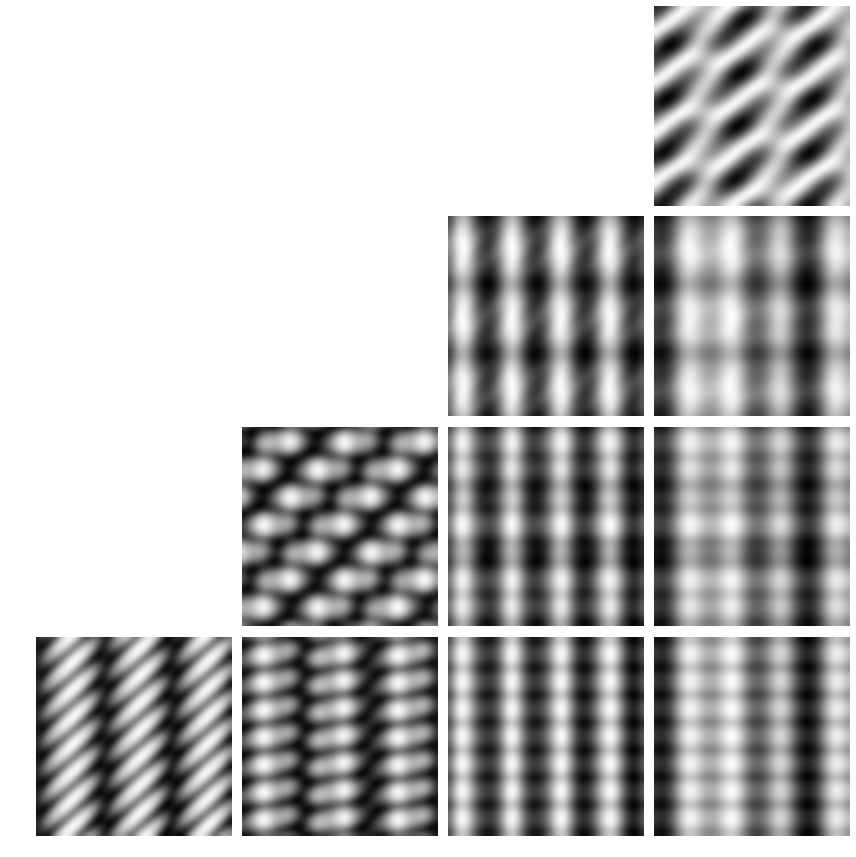

In [26]:
def plot_2d_grid(save=None):
    """Combine the results from each pair of interfaces into a single grid.
    """
    fig, ax = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12, 12))

    plot_absorption_2d(ax[0][3], absorb2d[(1,2)])
    ax[0][0].axis('off')
    ax[0][1].axis('off')
    ax[0][2].axis('off')

    plot_absorption_2d(ax[1][3], absorb2d[(1,3)])
    plot_absorption_2d(ax[1][2], absorb2d[(2,3)])
    ax[1][0].axis('off')
    ax[1][1].axis('off')

    plot_absorption_2d(ax[2][3], absorb2d[(1,4)])
    plot_absorption_2d(ax[2][2], absorb2d[(2,4)])
    plot_absorption_2d(ax[2][1], absorb2d[(3,4)])
    ax[2][0].axis('off')

    plot_absorption_2d(ax[3][3], absorb2d[(1,5)])
    plot_absorption_2d(ax[3][2], absorb2d[(2,5)])
    plot_absorption_2d(ax[3][1], absorb2d[(3,5)])
    plot_absorption_2d(ax[3][0], absorb2d[(4,5)])
    
    plt.tight_layout()
    if save:
        plt.savefig(save)

plot_2d_grid(save='fringes_2d.png')

### Simulated Random Fringe Patterns

Implement a simple model of fringing due to random variations in the thickness of two uncorrelated layers.

In [27]:
def generate_heightfield(fractal_dimension=2.5, n=512, seed=123):

    H = 1 - (fractal_dimension - 2)
    kpow = -(H + 1.0) / 2.0
    
    A = np.zeros((n, n), complex)

    kvec = np.fft.fftfreq(n)
    k0 = kvec[n // 64]
    kx, ky = np.meshgrid(kvec, kvec, sparse=True, copy=False)
    ksq = kx ** 2 + ky ** 2
    m = ksq > 0

    gen = np.random.RandomState(seed=seed)    
    phase = 2 * np.pi * gen.uniform(size=(n, n))
    A[m] = ksq[m] ** kpow * gen.normal(size=(n, n))[m] * np.exp(1.j * phase[m]) * np.exp(-ksq[m] / k0 ** 2)

    return np.fft.ifft2(A)

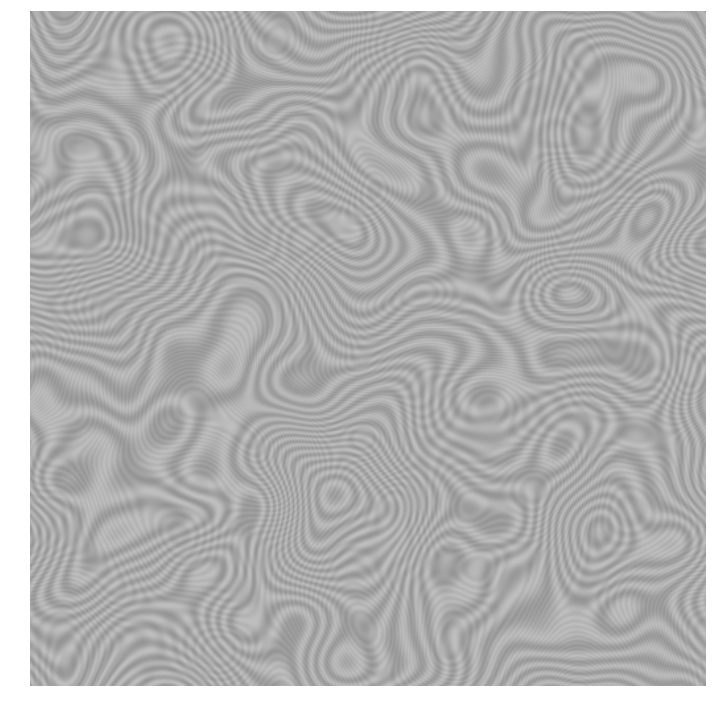

In [28]:
def simulate_fringes(n1=3.6, n2=1.5, amp1=0.02, amp2=0.05, nwaves_rms=10., seed=123, save=None):
    fig = plt.figure(figsize=(10, 10))
    X = generate_heightfield(2.5, 512, seed)
    X *= nwaves_rms / np.std(X.real)
    Z = amp1 * np.sin(2 * n1 * X.real) + amp2 * np.sin(2 * n2 * X.imag)

    vlim = np.max(np.abs(Z))
    plt.imshow(Z, cmap='gray', vmin=-8*vlim, vmax=+4*vlim)
    plt.axis('off')
    
    plt.tight_layout()
    if save:
        plt.savefig(save)

simulate_fringes(save='fringes.png')